In [18]:
from meanderutils import *
from styles import *
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3D, Line3DCollection
import pymesh

from matplotlib.colors import LightSource
from matplotlib.colors import to_rgb
from matplotlib.colors import to_hex



In [2]:

def find_path(paths, face):
    for i, path in enumerate(paths):
        if face in path:
            return i
    return -1



In [36]:
def recolor(color, brightness):
    return to_hex(np.array(to_rgb(color))*(brightness/2+0.5))


def faces_from_data(data, seed=100, iterations=100):
    #print(data["nodes"])
    G = nx.Graph(data["nodes"])
    #pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")

    #print(pos)
    pos = nx.spring_layout(G, dim=3, iterations=iterations, weight=1, seed=seed)
    #print(pos)
    faces = np.array(data["faces"])-1

    

    pos2 = np.array(list(pos.values()))

    first = pos2[faces[:,0:2]]
    second = pos2[faces[:,1:3]]

    normals = first-second
    #print(normals)
    #print(normals[:,0,:], normals[:,1,:])
    #print("BEGIN")
    #print()
    #print("END")
    #normals[]
    
    real_normals = np.cross(normals[:,0,:], normals[:,1,:])

    #print(cross_product_of_arr(normals))

    return pos2[faces], pos2, faces, real_normals

def draw_structure(file_name, index=0, seed=101, scale_factor=1.5, cmap='cmr.ocean', iterations=100):
    with open(file_name) as file:
        data100 = json.load(file)

        n = data100["configurations"][index]["n"]

        configuration = data100["configurations"][index]
        
        #face_group100 = VGroup()

        max_distance = np.max(configuration["face_distance"])
        colors = cmr.take_cmap_colors(cmap, max_distance, return_fmt='hex')

        #face_group100.scale(0.8)
        #print("max_distance", max_distance)
        faces, pos, _, normals = faces_from_data(configuration, seed=seed, iterations=iterations)
        ls = LightSource(azdeg=0, altdeg=65)
        result = ls.shade_normals(normals)
        print(result)
        tris = Poly3DCollection(faces*scale_factor, linewidth=0.02, color='black')
        #print(colors)#colors[dist-1]
        tris.set_facecolor([ colors[dist-1] for i, dist in enumerate(configuration["face_distance"])])
        #tris.set_facecolor(result)
        tris.set_alpha(0.8)

        

        return tris, pos, n
        # for (i, face) in enumerate():
        #     dist = configuration["face_distance"][i]
        #     #print("dist", dist)
        #     face_group100.add(Polygon(*(face*2), shade_in_3d=True, stroke_width=0.3).set_color(WHITE).set_fill(colors[dist-1], opacity=0.8))
        # return face_group100

def draw_structure_mesh(file_name, index=0, seed=101, scale_factor=1.5):
    with open(file_name) as file:
        data100 = json.load(file)

        n = data100["configurations"][index]["n"]

        configuration = data100["configurations"][index]
        
        #face_group100 = VGroup()

        max_distance = np.max(configuration["face_distance"])
        colors = cmr.take_cmap_colors('cmr.ocean', max_distance, return_fmt='hex')

        #face_group100.scale(0.8)
        #print("max_distance", max_distance)
        faces, pos, faces_, normals = faces_from_data(configuration, seed=seed)
        # tris = Poly3DCollection(faces*scale_factor, linewidth=0)
        # tris.set_facecolor([colors[dist-1] for dist in configuration["face_distance"]])
        # tris.set_alpha(0.8)
        # faces_from_data

        mesh = pymesh.form_mesh(pos, faces_)
        mesh.add_attribute("vertex_normal")
        mesh.set_attribute("vertex_normal", normals)
        mesh = pymesh.quad_to_tri(mesh)
        #mesh = pymesh.subdivide(mesh, order=2, method="loop")

        #print(mesh.get_attribute("vertex_normal"))

        pymesh.save_mesh("test.stl", mesh)
        

        #return tris, pos, n
        # for (i, face) in enumerate():
        #     dist = configuration["face_distance"][i]
        #     #print("dist", dist)
        #     face_group100.add(Polygon(*(face*2), shade_in_3d=True, stroke_width=0.3).set_color(WHITE).set_fill(colors[dist-1], opacity=0.8))
        # return face_group100


def draw_structure_advanced(file_name, index=0, seed=101, scale_factor=1.5, iterations=100):
    with open(file_name) as file:
        data100 = json.load(file)

        n = data100["configurations"][index]["n"]

        configuration = data100["configurations"][index]
        
        #face_group100 = VGroup()
        line_width = 2


        max_distance = np.max(configuration["face_distance"])
        colors = cmr.take_cmap_colors('cmr.ocean', max_distance, return_fmt='hex')

        colors_roads = cmr.take_cmap_colors('tab20', len(configuration["path"]), return_fmt='hex')

        #face_group100.scale(0.8)
        #print("max_distance", max_distance)
        faces, pos, _, _ = faces_from_data(configuration, seed=seed, iterations=iterations)
        tris = Poly3DCollection(faces*scale_factor, linewidth=0.4, color='black')
        tris.set_facecolor([colors[dist-1] for dist in configuration["face_distance"]])
        #tris.set_facecolor(["#FFF" for dist in configuration["face_distance"]])
        tris.set_alpha(0.8)

        scale_factor_ = scale_factor 

        faces_visited = set()

        river_lines = []

        for river in configuration["river_connections"]:
            face_id = river[2]

            if face_id in faces_visited:
                continue

            faces_visited.add(face_id)

            nodes_of_face = configuration["faces"][face_id-1]

            nodes_of_face_set = set(nodes_of_face)

            nodes_of_face_set.discard(river[0])
            nodes_of_face_set.discard(river[1])

            opposite = list(nodes_of_face_set)

            first_coord = (pos[river[0]-1] + pos[river[1]-1]) / 2
            second_coord = (pos[opposite[0]-1] + pos[opposite[1]-1]) / 2

            line_coords = np.array([first_coord, second_coord])
            #print(line_coords)
            river_lines.append(line_coords)
            
        linecol_river = Line3DCollection(np.array(river_lines)*scale_factor_, color='blue', linewidth=line_width, zorder=4.5)

        #bridge_lines = []
        faces_visited = set()

        lines3D_bridges = []

        for bridge in configuration["bridge_pillars"]:
            face_id = bridge[2]

            if face_id in faces_visited:
                continue

            faces_visited.add(face_id)

            nodes_of_face = configuration["faces"][face_id-1]

            nodes_of_face_set = set(nodes_of_face)

            nodes_of_face_set.discard(bridge[0])
            nodes_of_face_set.discard(bridge[1])

            opposite = list(nodes_of_face_set)

            first_coord = (pos[bridge[0]-1] + pos[bridge[1]-1]) / 2
            second_coord = (pos[opposite[0]-1] + pos[opposite[1]-1]) / 2

            line_coords = np.array([first_coord, second_coord])*scale_factor_
            #print(line_coords)
            lines3D_bridges.append(Line3D(*(line_coords.T), color=colors_roads[find_path(configuration["path"], face_id)], linewidth=line_width, zorder=4.5))
            #bridge_lines.append(line_coords)
            
        #linecol_bridge = Line3DCollection(np.array(bridge_lines)*scale_factor, color='blue', linewidth=line_width)
        

        return tris, pos, n, linecol_river, lines3D_bridges
        # for (i, face) in enumerate():
        #     dist = configuration["face_distance"][i]
        #     #print("dist", dist)
        #     face_group100.add(Polygon(*(face*2), shade_in_3d=True, stroke_width=0.3).set_color(WHITE).set_fill(colors[dist-1], opacity=0.8))
        # return face_group100

# Try

In [56]:
%matplotlib qt

#simdata = {(1, 128): 'simdata/meander_structure_new/q1.0000/n128/sim_data_20220804122529_1_0_0.json'}
simdata = {(1, 3): 'simdata/meander_structure_new/q1.0000/n3/sim_data_20220804122516_1_0_0.json'}
#simdata = {(0.1, 128): 'simdata/meander_structure_new/q0.1000/n128/sim_data_20220804133933_1_0_0.json'}
#simdata = {(20, 16): 'simdata/meander_structure_new/q20.0000/n16/sim_data_20220804134913_1_0_0.json'}
#simdata = {(20, 32): 'simdata/meander_structure_new/q20.0000/n32/sim_data_20220804151636_1_0_0.json'}

#simdata = {(1, 16): 'simdata/meander_structure_new/q1.0000/n16/sim_data_20220805103308_1_0_0.json'}

#simdata = {(20, 128): 'simdata/meander_structure_new/q20.0000/n128/sim_data_20220804134104_1_0_0.json'}


for key, path in simdata.items():
    fig = plt.figure(figsize=(3,3))
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)

    ax.set_axis_off()

    q, n = key
    tris, pos, n, lines_r, lines_bridges = draw_structure_advanced(path, seed=21, iterations=1000)
    #tris.set_alpha(0.2)
   
    
    ax.add_collection3d(lines_r)
    #ax.add_line(*lines_bridges)
    for line in lines_bridges:
        ax.add_line(line)
    #ax.add_collection3d(*lines_bridges)

    ax.add_collection3d(tris)

    ax.set_xlim3d(np.amin(pos[:,0]),np.amax(pos[:,0]))
    ax.set_ylim3d(np.amin(pos[:,1]),np.amax(pos[:,1]))
    ax.set_zlim3d(np.amin(pos[:,2]),np.amax(pos[:,2]))

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])

    ax.view_init(0, 0)

    plt.show()
    #plt.savefig("docs/results/assets/meanderchainplotq{}n{}.pdf".format(q, n), bbox_inches='tight')


[[1, 2], [2, 3], [3, 4], [4, 1], [4, 3], [3, 5], [5, 1], [1, 4], [1, 5], [5, 3], [3, 6], [6, 1], [6, 3], [3, 2], [2, 7], [7, 6], [7, 2], [2, 8], [8, 6], [6, 7], [6, 8], [8, 2], [2, 1], [1, 6]]
BEGIN
[[-0.29019     0.00115995 -0.24533492]
 [ 0.06992333  0.54019126  0.02661636]
 [ 0.07030172 -0.26027985  0.30224083]
 [ 0.30402491 -0.26777209 -0.00946533]
 [-0.44236632 -0.0138687  -0.31705113]
 [ 0.021854    0.37797278  0.03568269]]
END
[[-0.09135144  0.12945907 -0.07185077]
 [-0.39053893 -0.3466458   0.46229239]]
[[-0.39053893 -0.3466458   0.46229239]
 [-0.67647406 -0.06663533  0.15601535]]
[[-0.67647406 -0.06663533  0.15601535]
 [ 0.09192632 -0.1292364   0.07151764]]
[[ 0.09192632 -0.1292364   0.07151764]
 [ 0.42101756  0.42736236 -0.35574394]]
[[ 0.42101756  0.42736236 -0.35574394]
 [ 0.64599543 -0.01408123 -0.2625638 ]]
[[ 0.64599543 -0.01408123 -0.2625638 ]
 [-0.09135144  0.12945907 -0.07185077]]


In [27]:
#simdata = {(1, 3): 'simdata/meander_structure_new/q1.0000/n3/sim_data_20220804122516_1_0_0.json'}
simdata = {(0.1, 128): 'simdata/meander_structure_new/q0.1000/n128/sim_data_20220804133933_1_0_0.json'}

for key, path in simdata.items():
    q, n = key
    draw_structure_mesh(path, seed=21)


[[1, 2], [2, 3], [3, 4], [4, 1], [4, 3], [3, 5], [5, 1], [1, 4], [1, 5], [5, 6], [6, 7], [7, 1], [7, 6], [6, 8], [8, 9], [9, 7], [9, 8], [8, 6], [6, 10], [10, 9], [10, 6], [6, 11], [11, 9], [9, 10], [9, 11], [11, 12], [12, 7], [7, 9], [7, 12], [12, 13], [13, 1], [1, 7], [1, 13], [13, 14], [14, 15], [15, 1], [15, 14], [14, 16], [16, 17], [17, 15], [17, 16], [16, 18], [18, 19], [19, 17], [19, 18], [18, 16], [16, 20], [20, 19], [20, 16], [16, 14], [14, 21], [21, 20], [21, 14], [14, 13], [13, 22], [22, 21], [22, 13], [13, 12], [12, 21], [21, 22], [21, 12], [12, 11], [11, 20], [20, 21], [20, 11], [11, 6], [6, 19], [19, 20], [19, 6], [6, 23], [23, 24], [24, 19], [24, 23], [23, 6], [6, 25], [25, 24], [25, 6], [6, 26], [26, 24], [24, 25], [24, 26], [26, 27], [27, 19], [19, 24], [19, 27], [27, 26], [26, 17], [17, 19], [17, 26], [26, 28], [28, 15], [15, 17], [15, 28], [28, 29], [29, 30], [30, 15], [30, 29], [29, 31], [31, 15], [15, 30], [15, 31], [31, 29], [29, 1], [1, 15], [1, 29], [29, 28], [2

# Real

[0.33528011 0.31489071 0.34093662 0.29621953 0.27732603 0.3850882
 0.33060245 0.51545347 0.35997369 0.32958669 0.35145366 0.24235994
 0.29112199 0.37597671 0.42484254 0.62083693 0.59580459 0.40916225
 0.35674299 0.30118542 0.25392059 0.56031565 0.38711084 0.25935014
 0.14199102 0.23998425 0.35314303 0.24476654 0.29501967 0.3232979
 0.35927219 0.38395027 0.50612819 0.61057509 0.5139117  0.34472269
 0.27074808 0.41836825 0.47038308 0.30490137 0.19825158 0.26604967
 0.31670625 0.25688429 0.27792345 0.30063905 0.19823795 0.
 0.28735074 0.33614177 0.23172205 0.16563141 0.03106047 0.12316835
 0.23740604 0.20593381 0.266778   0.31983089 0.47641757 0.34951272
 0.33453134 0.36098866 0.39238391 0.25075709 0.23311727 0.21440023
 0.3565845  0.3592978  0.3227446  0.31716588 0.33330557 0.36884021
 0.31366756 0.33626646 0.29242947 0.2533166  0.26353581 0.20119032
 0.25479716 0.41240531 0.65166948 0.31227746 0.13650503 0.02290524
 0.18794684 0.21994608 0.32180934 0.3088908  0.35878249 0.2915667
 0.367

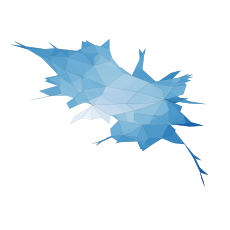

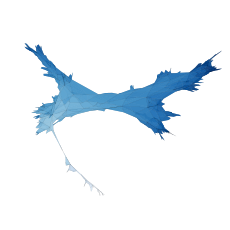

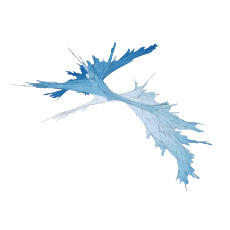

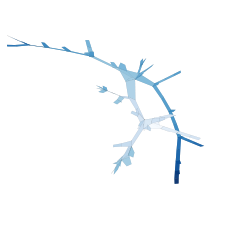

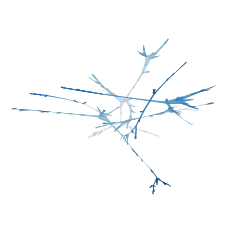

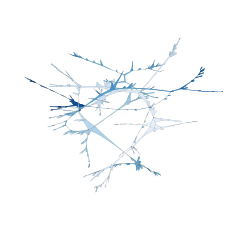

In [38]:


#ax.set_title("(a)")

# q1 n100
# simdata/meander_chain/q1.0000/n100/sim_data_20220611221655_1_0_0.json
# simdata/meander_chain/q1.0000/n500/sim_data_20220611222927_1_0_0.json
# simdata/meander_chain/q1.0000/n1000/sim_data_20220611224724_1_0_0.json




simdata = {(1, 100): 'simdata/meander_chain/q1.0000/n100/sim_data_20220611221655_1_0_0.json',
     (1, 500): 'simdata/meander_chain/q1.0000/n500/sim_data_20220611222927_1_0_0.json',
     (1, 1000): 'simdata/meander_chain/q1.0000/n1000/sim_data_20220611224724_1_0_0.json',
      (20, 100): 'simdata/meander_chain/q20.0000/n100/sim_data_20220611220055_1_0_0.json',
     (20, 500): 'simdata/meander_chain/q20.0000/n500/sim_data_20220611220111_1_0_0.json',
     (20, 1000): 'simdata/meander_chain/q20.0000/n1000/sim_data_20220611220134_1_0_0.json'
}

# q20
# simdata/meander_chain/q20.0000/n100/sim_data_20220611220055_1_0_0.json
# simdata/meander_chain/q20.0000/n500/sim_data_20220611220111_1_0_0.json
# simdata/meander_chain/q20.0000/n1000/sim_data_20220611220134_1_0_0.json

# q20 = {100: 'simdata/meander_chain/q20.0000/n100/sim_data_20220611220055_1_0_0.json',
#       500: 'simdata/meander_chain/q20.0000/n500/sim_data_20220611220111_1_0_0.json',
#       1000: 'simdata/meander_chain/q20.0000/n1000/sim_data_20220611220134_1_0_0.json'}

# simdata/meander_chain/q0.1000/n100/sim_data_20220611220228_1_0_0.json
# simdata/meander_chain/q20.0000/n100/sim_data_20220611220055_1_0_0.json
#tris, pos = draw_structure("simdata/meander_chain/q0.1000/n100/sim_data_20220611220228_1_0_0.json")

q = 20
n = 1000

for key, path in simdata.items():
    fig = plt.figure(figsize=(3,3))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    ax.set_axis_off()

    q, n = key
    tris, pos, n = draw_structure(path, cmap='Blues', iterations=200)
    ax.add_collection3d(tris)

    ax.set_xlim3d(np.amin(pos[:,0]),np.amax(pos[:,0]))
    ax.set_ylim3d(np.amin(pos[:,1]),np.amax(pos[:,1]))
    ax.set_zlim3d(np.amin(pos[:,2]),np.amax(pos[:,2]))

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])

    ax.view_init(0, 0)

    #plt.show()
    plt.savefig("docs/results/assets/meanderchainplotq{}n{}.png".format(q, n), dpi=600, bbox_inches='tight')
